## Training of the neural network for the X-ray reconstruction

In the following notebook, an hexsample simulation will be extracted, preprocessed and used for training a neural network for inferring the X-ray energy and its hit position.  
In this attempt, two separate NN are created, one for the position, one for the energy. The training will be done using a dataset from a Cu source (so, double-peaked pdf) and with 20 ENC (the most probable configuration for the future chip).

In [49]:
import os

import numpy as np

from IPython import display

# importing the necessary keras modules for model creation, training and saving
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# importing the custom libraries
from xrayreco.preprocessing import Xraydata
from hexsample.fileio import ReconInputFile, DigiInputFileCircular

### Data preprocessing and preliminary visualization
In the following, we will use a simulation where the electronic noise of every pixel is set to zero. The `.h5` file will be opened, the inuput and target data for the NNs will be extracted and the distribution visualized. 

In [3]:
# Loading an hexsample simulation and storing its content into an Xraydata object
# The following simulation is a simulation with no electronic noise.
file_path = '/Users/chiara/hexsampledata/hxsim_20ENC.h5'
# Creating an istance of the class Xraydata that contains the data preprocessing methods
data = Xraydata(file_path)

>>> Opening input file /Users/chiara/hexsampledata/hxsim_20ENC.h5...
>>> File type: FileType.DIGI


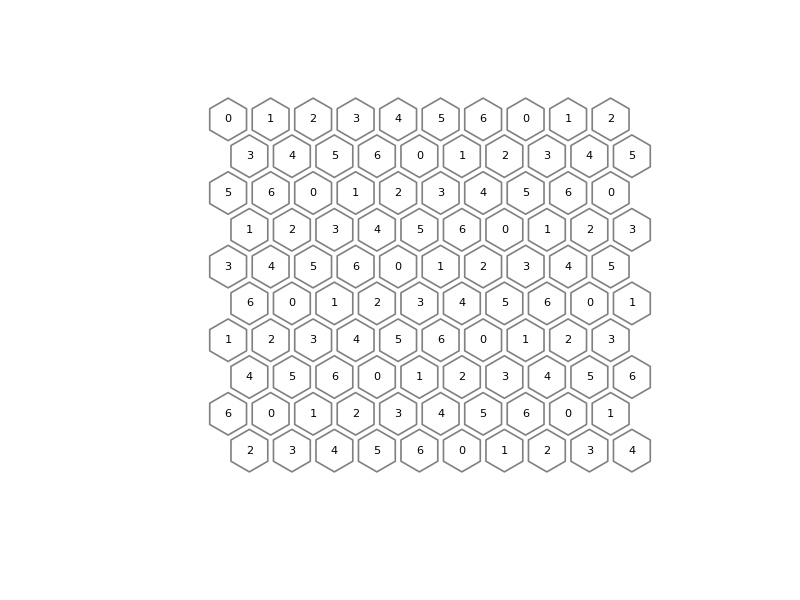

In [5]:
# Showing the hexagonal grid for reference
display.Image("../figures/Hexagonal_routing_7_HexagonalLayout.ODD_R.png")

This disposition of the hexagonal grid is labelled as `ODD_R` (see https://www.redblobgames.com/grids/hexagons/#coordinates-offset). 

In [6]:
# The Xraydata object contains methods for preprocessing that give the input and training output for the NN
input_data = data.input_events_data()
# Obtaining training output data from MC truth
target_data = data.target_data()

1000000it [00:34, 28605.33it/s]


In [6]:
# When data are no more needed, we can close the datafile
data.close_input_file()

In [7]:
# Printing the input data of the first event and the shape of the overall input array
print(f'Event 0: {input_data[0]}')
print(f'Input data shape: {input_data.shape}')

Event 0: [[ 1.90900000e+03  0.00000000e+00  0.00000000e+00]
 [ 9.40000000e+01  3.00000000e-03  5.19615242e-03]
 [ 1.20000000e+01  6.00000000e-03  0.00000000e+00]
 [ 1.40000000e+01  3.00000000e-03 -5.19615242e-03]
 [ 6.00000000e+00 -3.00000000e-03 -5.19615242e-03]
 [ 1.00000000e+00 -6.00000000e-03  0.00000000e+00]
 [ 4.42000000e+02 -3.00000000e-03  5.19615242e-03]]
Input data shape: (1000000, 7, 3)


As we can see, the input data is a numpy array of shape (n, 7, 3), where:
- n is the number of simulated events;
- 7 is the number of pixels of every event track;
- 3 is the number of informations contained in every pixel: (pha, x, y).  

In [6]:
# Printing the target array of the first event and the shape of the overall target array
print(f'Energy = {target_data[0][0]}')
print(f'Hit coordinates: ({target_data[0][1:]})')
print(f'Target data shape: {target_data.shape}')

Energy = 8026.7001953125
Hit coordinates: ([-0.00012503 -0.0001334 ])
Target data shape: (1000000, 3)


Energy array [8903.90039062 8046.29980469 8046.29980469 ... 8046.29980469 8046.29980469
 8026.70019531]


Text(0.5, 0, 'Photon energy [eV]')

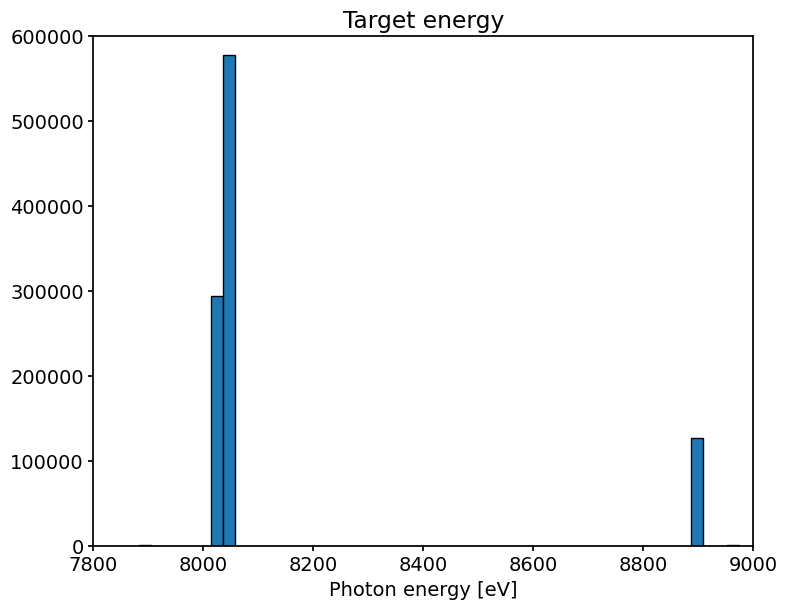

In [8]:
#Printing the energy array and plotting the energy distribution
print(f'Energy array {target_data[:,0]}')
plt.title('Target energy')
plt.hist(target_data[:,0], bins=50)
plt.xlabel('Photon energy [eV]')

Text(0.5, 0, 'x displacement from the center of the central signal pixel [cm]')

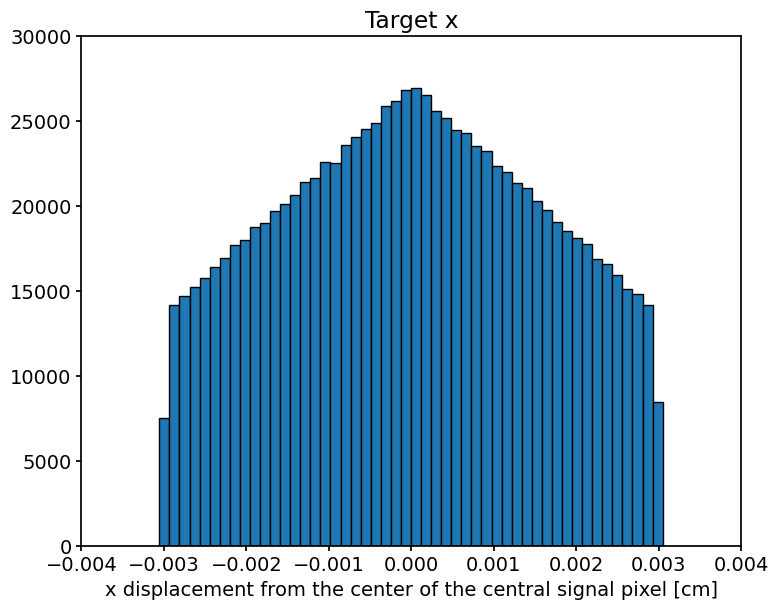

In [9]:
# Doing the same for the hit coordinates
# Plotting the histogram of the x-hit coordinates
plt.title('Target x')
plt.hist(target_data[:,1], bins=50)
plt.xlabel('x displacement from the center of the central signal pixel [cm]')

Text(0.5, 0, 'y displacement from the center of the central signal pixel [cm]')

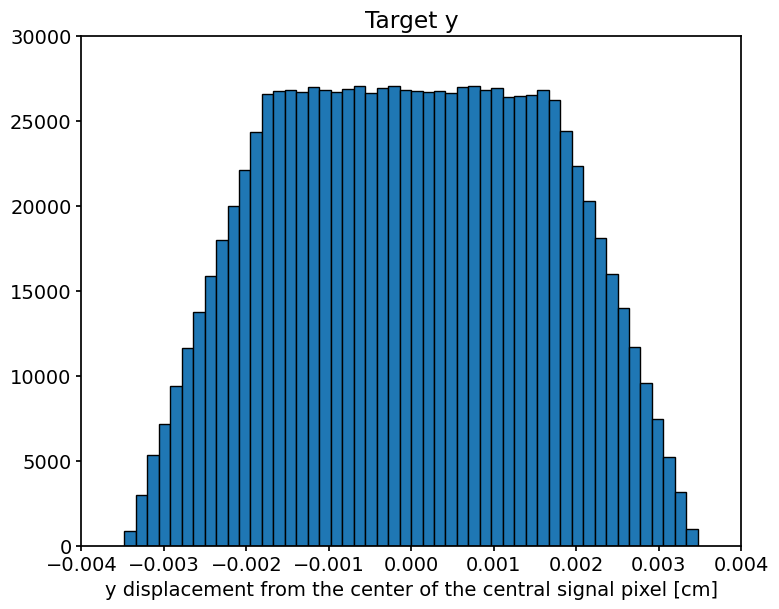

In [10]:
# Doing the same for the hit coordinates
# Plotting the histogram of the y-hit coordinates
plt.title('Target y')
plt.hist(target_data[:,2], bins=50)
plt.xlabel('y displacement from the center of the central signal pixel [cm]')

### Neural Network definition and training
#### Neural Network for energy regression

In [53]:
# Standardizing input data
# This is a pt where I can think a parallelization for large datasets
scaler = StandardScaler()
X = scaler.fit_transform(input_data.reshape(-1, input_data.shape[-1])).reshape(input_data.shape)

In [15]:
# Creating the FFNN models. One for energy regression, one for position regression
# define NN model, compile and train
model_e = Sequential([
                    Flatten(input_shape=(7,3)),
                    BatchNormalization(),
                    Dense(20, activation='relu'),
                    Dense(50, activation='relu'),
                    Dense(50, activation='relu'),
                    Dense(50, activation='relu'),
                    Dense(10, activation='relu'),
                    Dense(1, activation='linear')
                    ])

model_e.compile(optimizer='adam', loss='MSE',)

model_e.summary()


/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 21)             │            84 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         1,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,195 (28.11 KB)

 Trainable params: 7,153 (27.94 KB)

 Non-trainable params: 42 (168.00 B)

In [17]:
# Loading the last model weights if already trained at least once
checkpoint_path = "../training_2NN/cp_e.weights.h5"
model_e.load_weights(checkpoint_path)


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../training_2NN/cp_e.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [65]:
# Defining the path and directory for checkpoints that save the model's weights.
checkpoint_path = "../training_2NN/cp_e_norescale.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

#Training the NN for energy regression
history_e = model_e.fit(input_data, target_data[:,0], validation_split=0.05, epochs=20, callbacks=[cp_callback])


Epoch 1/20
29591/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 42762.5000
Epoch 1: saving model to ../training_2NN/cp_e_norescale.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 15s 501us/step - loss: 42763.1172 - val_loss: 31144.2715
Epoch 2/20
29602/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 42869.0898
Epoch 2: saving model to ../training_2NN/cp_e_norescale.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 15s 492us/step - loss: 42869.0742 - val_loss: 30617.5059
Epoch 3/20
29674/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 42999.6328
Epoch 3: saving model to ../training_2NN/cp_e_norescale.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 15s 503us/step - loss: 42999.6328 - val_loss: 32143.9824
Epoch 4/20
29613/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 42682.0977
Epoch 4: saving model to ../training_2NN/cp_e_norescale.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 14s 486us/step - loss: 42682.7266 - val_loss: 31109.4219
Epoch 5/20
29582/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss

dict_keys(['loss', 'val_loss'])


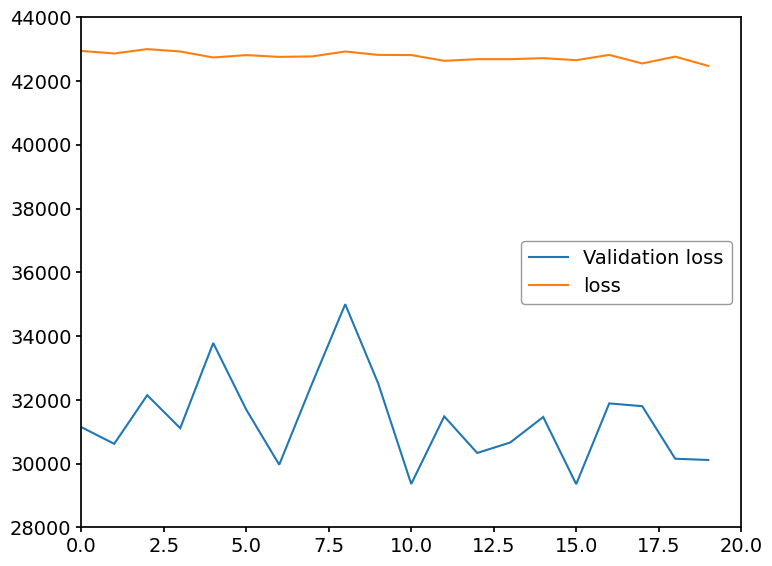

In [66]:
print(history_e.history.keys())
plt.plot(history_e.history['val_loss'], label='Validation loss')
plt.plot(history_e.history['loss'], label='loss')
plt.legend()
plt.show()

This is weird.. []

After the training, we want to compare the performance of the NN wrt the target data and wrt the standard reconstruction analysis. We will use as training data another simulation with the same parameters as the training one, reconstruct that and compare the interesting metrics.  
For the energy, the interesting metrics are:
- the energy shifts from the real values;
- the energy resolutions.


In [21]:
# Opening the test data file
test_data = Xraydata('/Users/chiara/hexsampledata/hxsim20ENC_test.h5')

>>> Opening input file /Users/chiara/hexsampledata/hxsim20ENC_test.h5...
>>> File type: FileType.DIGI


In [22]:
# Opening the reconstructed file relative to the test data
recon_file = ReconInputFile('/Users/chiara/hexsampledata/hxsim20ENC_test_recon.h5')

>>> Opening input file /Users/chiara/hexsampledata/hxsim20ENC_test_recon.h5...
>>> File type: FileType.RECON


In [23]:
# Obtaining the reconstructed energy
recon_energies = recon_file.column('energy')
recon_x = recon_file.column('posx')
recon_y = recon_file.column('posy')

In [24]:
# Extrapolating input data and predicting the target using the NN
test_input_data = test_data.input_events_data()
test_target_data = test_data.target_data()
test_data.close_input_file()


10000it [00:00, 27413.34it/s]


Predicting the test data using the NN in order to evaluate the performances

In [58]:
X_test = scaler.fit_transform(test_input_data.reshape(-1, test_input_data.shape[-1])).reshape(test_input_data.shape)

In [59]:
predicted_data_e = model_e.predict(X_test)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 9s 279us/step


(array([544903., 163992., 129115.,  51741.,  18136.,   8407.,   4024.,
          3572.,   2577.,   1916.,   1453.,   1369.,   1430.,   1542.,
          1626.,   1718.,   2119.,   2939.,  42297.,  15124.]),
 array([7991.586 , 8039.0015, 8086.417 , 8133.8325, 8181.248 , 8228.664 ,
        8276.079 , 8323.494 , 8370.91  , 8418.326 , 8465.741 , 8513.156 ,
        8560.572 , 8607.988 , 8655.403 , 8702.818 , 8750.234 , 8797.65  ,
        8845.065 , 8892.48  , 8939.896 ], dtype=float32),
 <BarContainer object of 20 artists>)

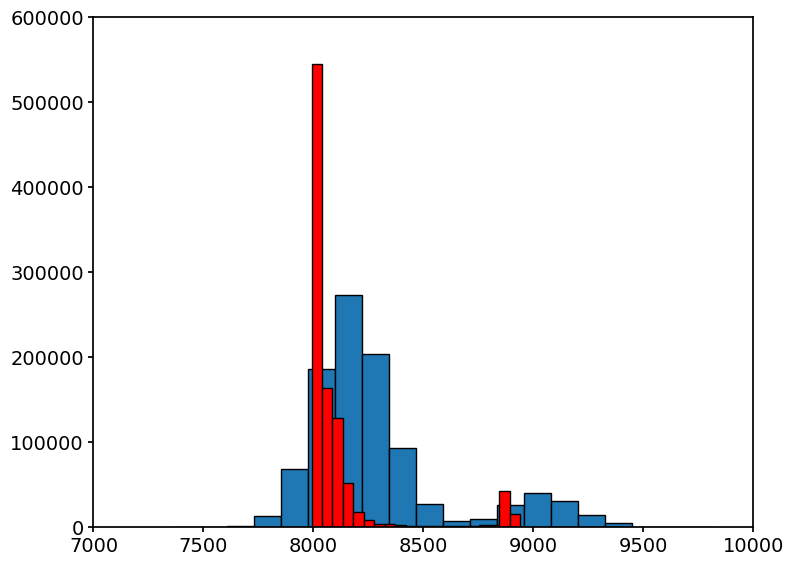

In [60]:
plt.hist(recon_energies, 20)
plt.hist(predicted_data_e, 20, color='red')

In [67]:
predicted_data_e = model_e.predict(test_input_data)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 9s 282us/step


(array([565026., 166332., 131195.,  36392.,  18303.,   5879.,   2763.,
          2127.,   1687.,   1283.,   1182.,   1232.,   1341.,   1385.,
          1573.,   1723.,   2049.,   3082.,  53691.,   1755.]),
 array([8057.284 , 8106.5156, 8155.7476, 8204.9795, 8254.211 , 8303.442 ,
        8352.674 , 8401.905 , 8451.138 , 8500.369 , 8549.601 , 8598.832 ,
        8648.063 , 8697.296 , 8746.527 , 8795.759 , 8844.99  , 8894.222 ,
        8943.454 , 8992.686 , 9041.917 ], dtype=float32),
 <BarContainer object of 20 artists>)

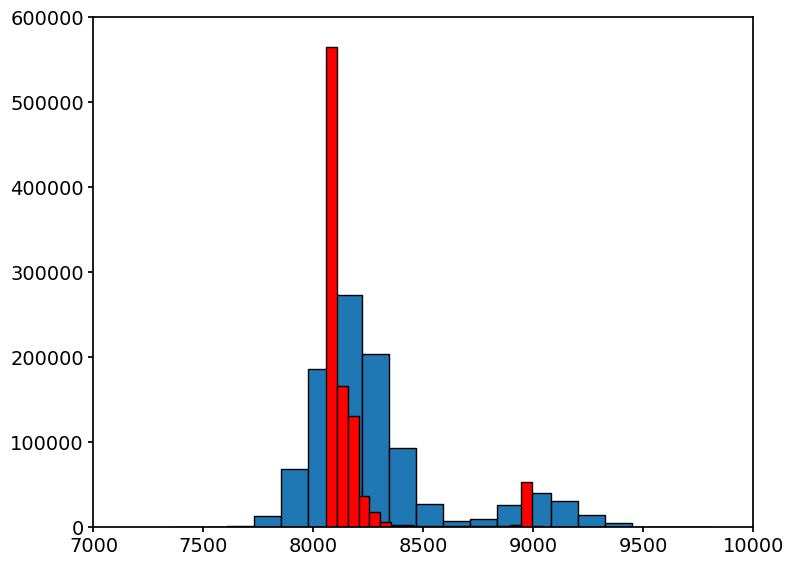

In [68]:
plt.hist(recon_energies, 20)
plt.hist(predicted_data_e, 20, color='red')

With or without rescale is the same for the energy.

In [93]:
# Creating the FFNN model for hit position reconstruction
# define NN model, compile and train
model_xy = Sequential([
                    Input(shape=(7,3)),
                    Flatten(),
                    BatchNormalization(),
                    Dense(30, activation='relu'),
                    Dense(50, activation='relu'),
                    Dense(100, activation='relu'),
                    Dense(50, activation='relu'),
                    Dense(30, activation='relu'),
                    Dense(2, activation='linear')
                    ])

model_xy.compile(optimizer='adam', loss='MSE')

model_xy.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 21)             │            84 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 30)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 50)             │         1,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │            62 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,036 (54.83 KB)

 Trainable params: 13,994 (54.66 KB)

 Non-trainable params: 42 (168.00 B)

In [94]:
# Defining the path and directory for checkpoints that save the model's weights.
checkpoint_path_xy = "training_1/cp_xy.weights.h5"
checkpoint_dir_xy = os.path.dirname(checkpoint_path_xy)

# Create a callback that saves the model's weights
cp_callback_xy = ModelCheckpoint(filepath=checkpoint_path_xy, save_weights_only=True, verbose=1)

#Training the NN for hit position regression
history_xy = model_xy.fit(input_data, target_data[:,1:], validation_split=0.05, epochs=20, callbacks=[cp_callback_xy])

Epoch 1/20
29639/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 1.1179e-05
Epoch 1: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 16s 524us/step - loss: 1.1164e-05 - val_loss: 5.7378e-07
Epoch 2/20
29668/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 5.9420e-07
Epoch 2: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 15s 513us/step - loss: 5.9419e-07 - val_loss: 5.4465e-07
Epoch 3/20
29620/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 5.8815e-07
Epoch 3: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 16s 523us/step - loss: 5.8814e-07 - val_loss: 7.5209e-07
Epoch 4/20
29615/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 5.8122e-07
Epoch 4: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 16s 537us/step - loss: 5.8123e-07 - val_loss: 4.3309e-07
Epoch 5/20
29647/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 5.8099e-07
Epoch 5: saving model to training_1/cp_xy.w

dict_keys(['loss', 'val_loss'])


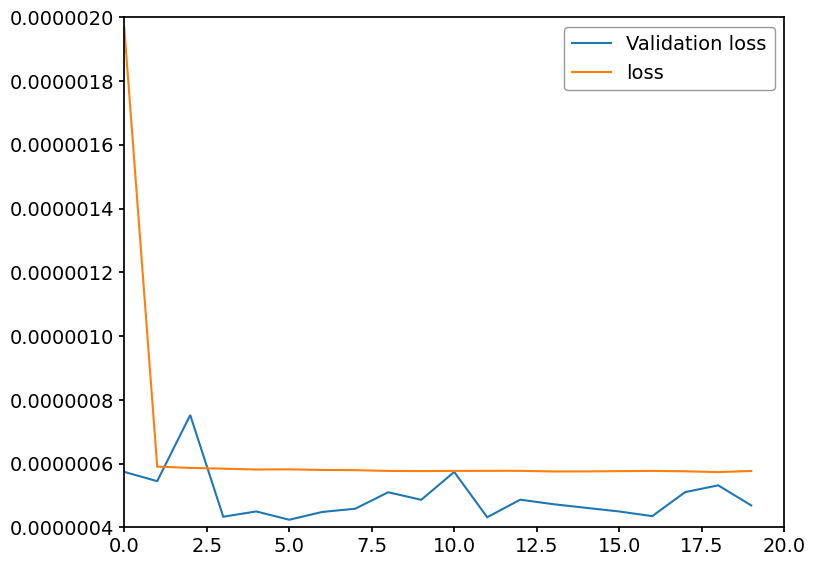

In [95]:
print(history_xy.history.keys())
plt.plot(history_xy.history['val_loss'], label='Validation loss')
plt.plot(history_xy.history['loss'], label='loss')
plt.legend()
plt.show()

In [74]:
# Opening the reconstructed file relative to the test data
test_file = Xraydata('/Users/chiara/hexsampledata/hxsim20ENC_0.02srcsigma.h5')

>>> Opening input file /Users/chiara/hexsampledata/hxsim20ENC_0.02srcsigma.h5...
>>> File type: FileType.DIGI


In [75]:
recon_file = ReconInputFile('/Users/chiara/hexsampledata/hxsim20ENC_0.02srcsigma_recon.h5')

>>> Opening input file /Users/chiara/hexsampledata/hxsim20ENC_0.02srcsigma_recon.h5...
>>> File type: FileType.RECON


In [76]:
# Obtaining the reconstructed energy
recon_energies = recon_file.column('energy')
recon_x = recon_file.column('posx')
recon_y = recon_file.column('posy')

In [77]:
x_max, y_max = test_file.highest_pixel_coordinates()


In [78]:
test_input_data = test_file.input_events_data()
test_target_data = test_file.target_data()

10000it [00:00, 21854.76it/s]


In [88]:
model_xy.load_weights('training_1/cp_xy.weights.h5')

In [96]:
predicted_data_xy = model_xy.predict(test_input_data)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step


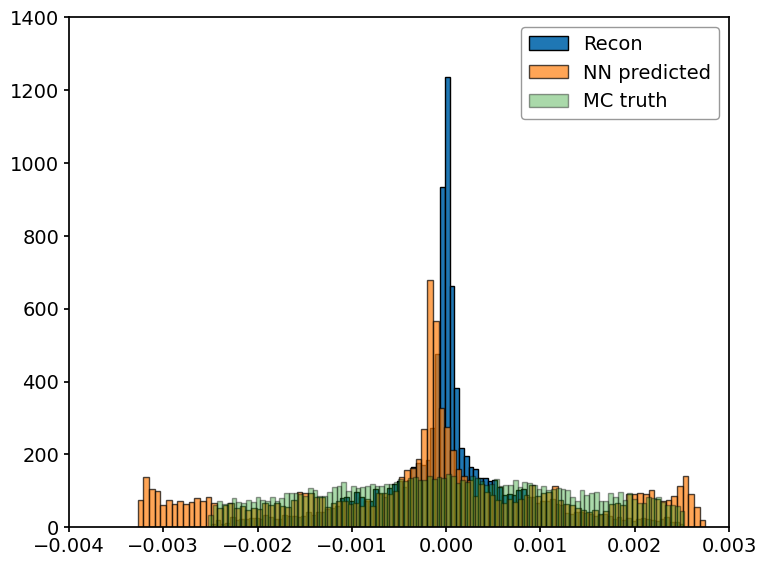

In [97]:
# Plotting the x position distribution and the relative recon
plt.figure()
plt.hist(recon_x - x_max, 100, label='Recon')
plt.hist(predicted_data_xy[:,0], 100, alpha=0.7, label='NN predicted')
plt.hist(test_target_data[:,1], 100, alpha=0.4, label='MC truth')

plt.legend()

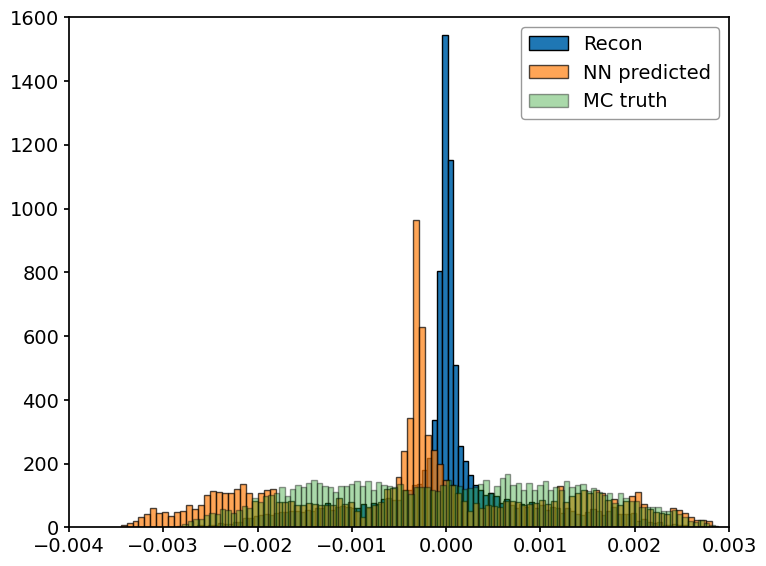

In [98]:
# Plotting the x position distribution and the relative recon
plt.figure()
plt.hist(recon_y - y_max, 100, label='Recon')
plt.hist(predicted_data_xy[:,1], 100, alpha=0.7, label='NN predicted')
plt.hist(test_target_data[:,2], 100, alpha=0.4, label='MC truth')

plt.legend()

This makes sense to me. Energy and position have two completely different distributions and weights and so the best thing to do is having two different NN. 

Let's see if training for more epochs is useful (even if the loss seemed to have reach a plateau very soon)

In [42]:
#Training the NN for hit position regression
history_xy = model_xy.fit(input_data, target_data[:,1:], validation_split=0.05, epochs=50, callbacks=[cp_callback_xy])

Epoch 1/50
29613/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 5.7464e-07
Epoch 1: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 15s 512us/step - loss: 5.7465e-07 - val_loss: 4.7614e-07
Epoch 2/50
29642/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 5.7454e-07
Epoch 2: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 15s 510us/step - loss: 5.7454e-07 - val_loss: 4.0136e-07
Epoch 3/50
29597/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 5.7905e-07
Epoch 3: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 15s 496us/step - loss: 5.7904e-07 - val_loss: 4.3807e-07
Epoch 4/50
29652/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 5.8057e-07
Epoch 4: saving model to training_1/cp_xy.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 15s 508us/step - loss: 5.8056e-07 - val_loss: 5.0401e-07
Epoch 5/50
29671/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 5.7743e-07
Epoch 5: saving model to training_1/cp_xy.w

In [43]:
predicted_data_xy = model_xy.predict(test_input_data)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 9s 301us/step


[Text(0.5, 0, '$y-y_{max}$')]

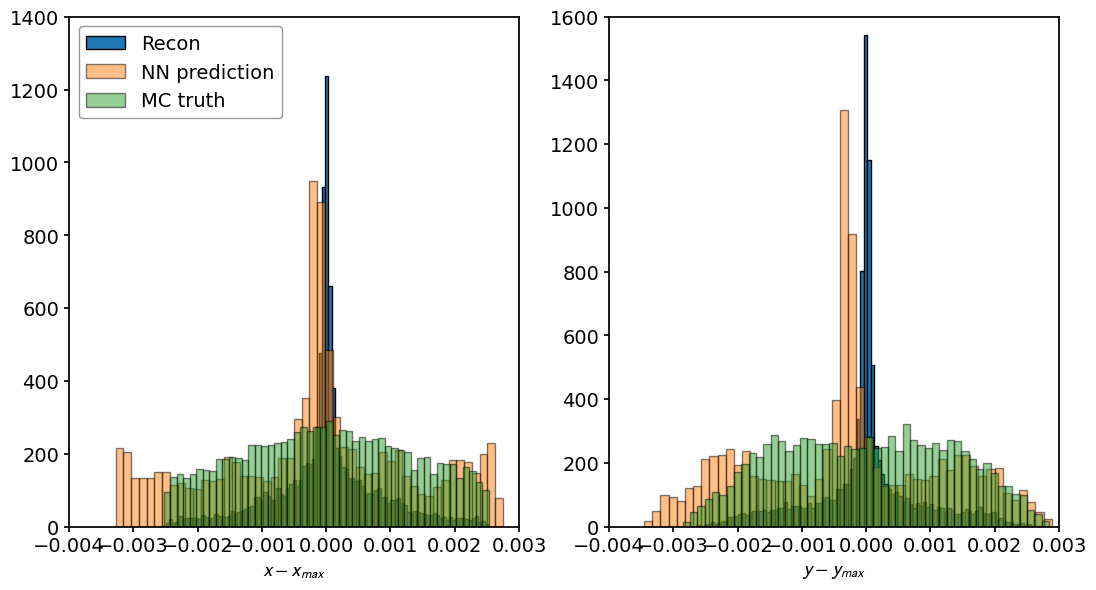

In [100]:
# Plotting the x and y target distribution
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
ax1.hist(recon_x - x_max, 100, label='Recon')
ax1.hist(predicted_data_xy[:,0], alpha=0.5, bins=50, label='NN prediction')
ax1.hist(test_target_data[:,1], alpha=0.5, bins=50, label='MC truth')
ax1.legend()
ax1.set(xlabel=r'$x-x_{max}$')
ax2.hist(recon_y - y_max, 100, label='Recon')
ax2.hist(predicted_data_xy[:,1], alpha=0.5, bins=50, label='NN prediction')
ax2.hist(test_target_data[:,2], alpha=0.5, bins=50, label='MC truth')
ax2.set(xlabel=r'$y-y_{max}$')

Didn't really change... maybe more and more params but anyway the NN wrt the classical reconstruction does not suffer of asymmetry due to the disposition of the pixels (indeed the NN does not know anything about the hexagonal grid...). 

Another trial is changing the scaler, this could be a good idea for the position wrt the center but not for the energy, anyway makes sense trying [].

### Repeating the training changing the starting normalization

In [69]:
# Standardizing input data
# This is a pt where I can think a parallelization for large datasets
scalerminmax = MinMaxScaler()
X_minmax = scalerminmax.fit_transform(input_data.reshape(-1, input_data.shape[-1])).reshape(input_data.shape)

In [70]:
# Defining the path and directory for checkpoints that save the model's weights.
checkpoint_path_xy = "training_1/cp_xy_minmax.weights.h5"
checkpoint_dir_xy = os.path.dirname(checkpoint_path_xy)

# Create a callback that saves the model's weights
cp_callback_xy = ModelCheckpoint(filepath=checkpoint_path_xy, save_weights_only=True, verbose=1)

#Training the NN for hit position regression
history_xy = model_xy.fit(X_minmax, target_data[:,1:], validation_split=0.05, epochs=20, callbacks=[cp_callback_xy])

Epoch 1/20
29605/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 5.5606e-07
Epoch 1: saving model to training_1/cp_xy_minmax.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 15s 503us/step - loss: 5.5606e-07 - val_loss: 7.3205e-07
Epoch 2/20
29683/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 5.5300e-07
Epoch 2: saving model to training_1/cp_xy_minmax.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 15s 493us/step - loss: 5.5300e-07 - val_loss: 4.5486e-07
Epoch 3/20
29633/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 5.5182e-07
Epoch 3: saving model to training_1/cp_xy_minmax.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 17s 566us/step - loss: 5.5182e-07 - val_loss: 4.6952e-07
Epoch 4/20
29612/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 5.5271e-07
Epoch 4: saving model to training_1/cp_xy_minmax.weights.h5
29688/29688 ━━━━━━━━━━━━━━━━━━━━ 15s 507us/step - loss: 5.5270e-07 - val_loss: 5.6092e-07
Epoch 5/20
29587/29688 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 5.5315e-07
Epoch 5: saving

In [84]:
X_test_minmax = scalerminmax.fit_transform(test_input_data.reshape(-1, test_input_data.shape[-1])).reshape(test_input_data.shape)
predicted_data_xy = model_xy.predict(X_test_minmax)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


[Text(0.5, 0, '$y-y_{max}$')]

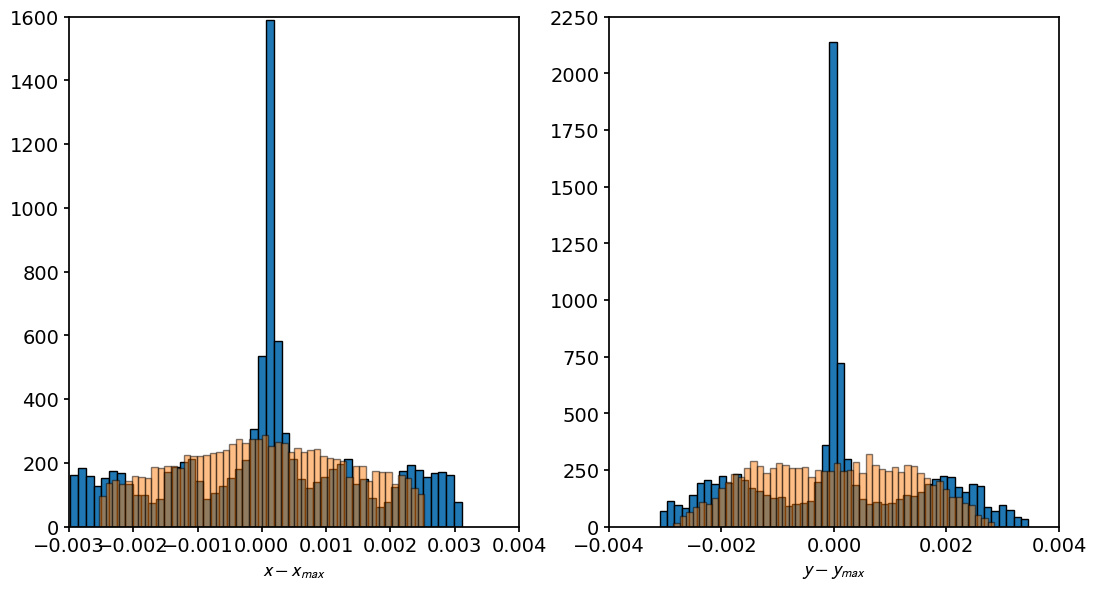

In [85]:
# Plotting the x and y target distribution
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
ax1.hist(predicted_data_xy[:,0], bins=50)
ax1.hist(test_target_data[:,1], alpha=0.5, bins=50)
ax1.set(xlabel=r'$x-x_{max}$')
ax2.hist(predicted_data_xy[:,1], bins=50)
ax2.hist(test_target_data[:,2], alpha=0.5, bins=50)
ax2.set(xlabel=r'$y-y_{max}$')